# Example notebook integrating Textract and Comprehend

This notebook
    1. sets up Textract's model so that we can call the endpoint via boto
    2. Displays a scanned image from the DeepAR published paper
    3. Calls Textract to extract the text from the scanned picture
        *. First we read in the byte array
        *. convert it to a base64 encoding
        *. call textract passing in the encoded byte array
    4. Then we use comprehend to extract entities and key phrases.

### Setup the boto environment
This assumes you have recieved preview before February 12th 2019
https://docs.aws.amazon.com/textract/latest/dg/setup-awscli-sdk.html
    

In [61]:
!aws s3 cp s3://amazon-textract-preview/service-2.json SageMaker/textract/
!aws configure add-model --service-model file://SageMaker/textract/service-2.json --service-name textract
    
TEXTRACT_REGION = 'us-east-1'
COMPREHEND_REGION = 'us-east-1'

download: s3://amazon-textract-preview/service-2.json to SageMaker/textract/service-2.json


### Display the scanned image
This a sample page from the DeepAR paper

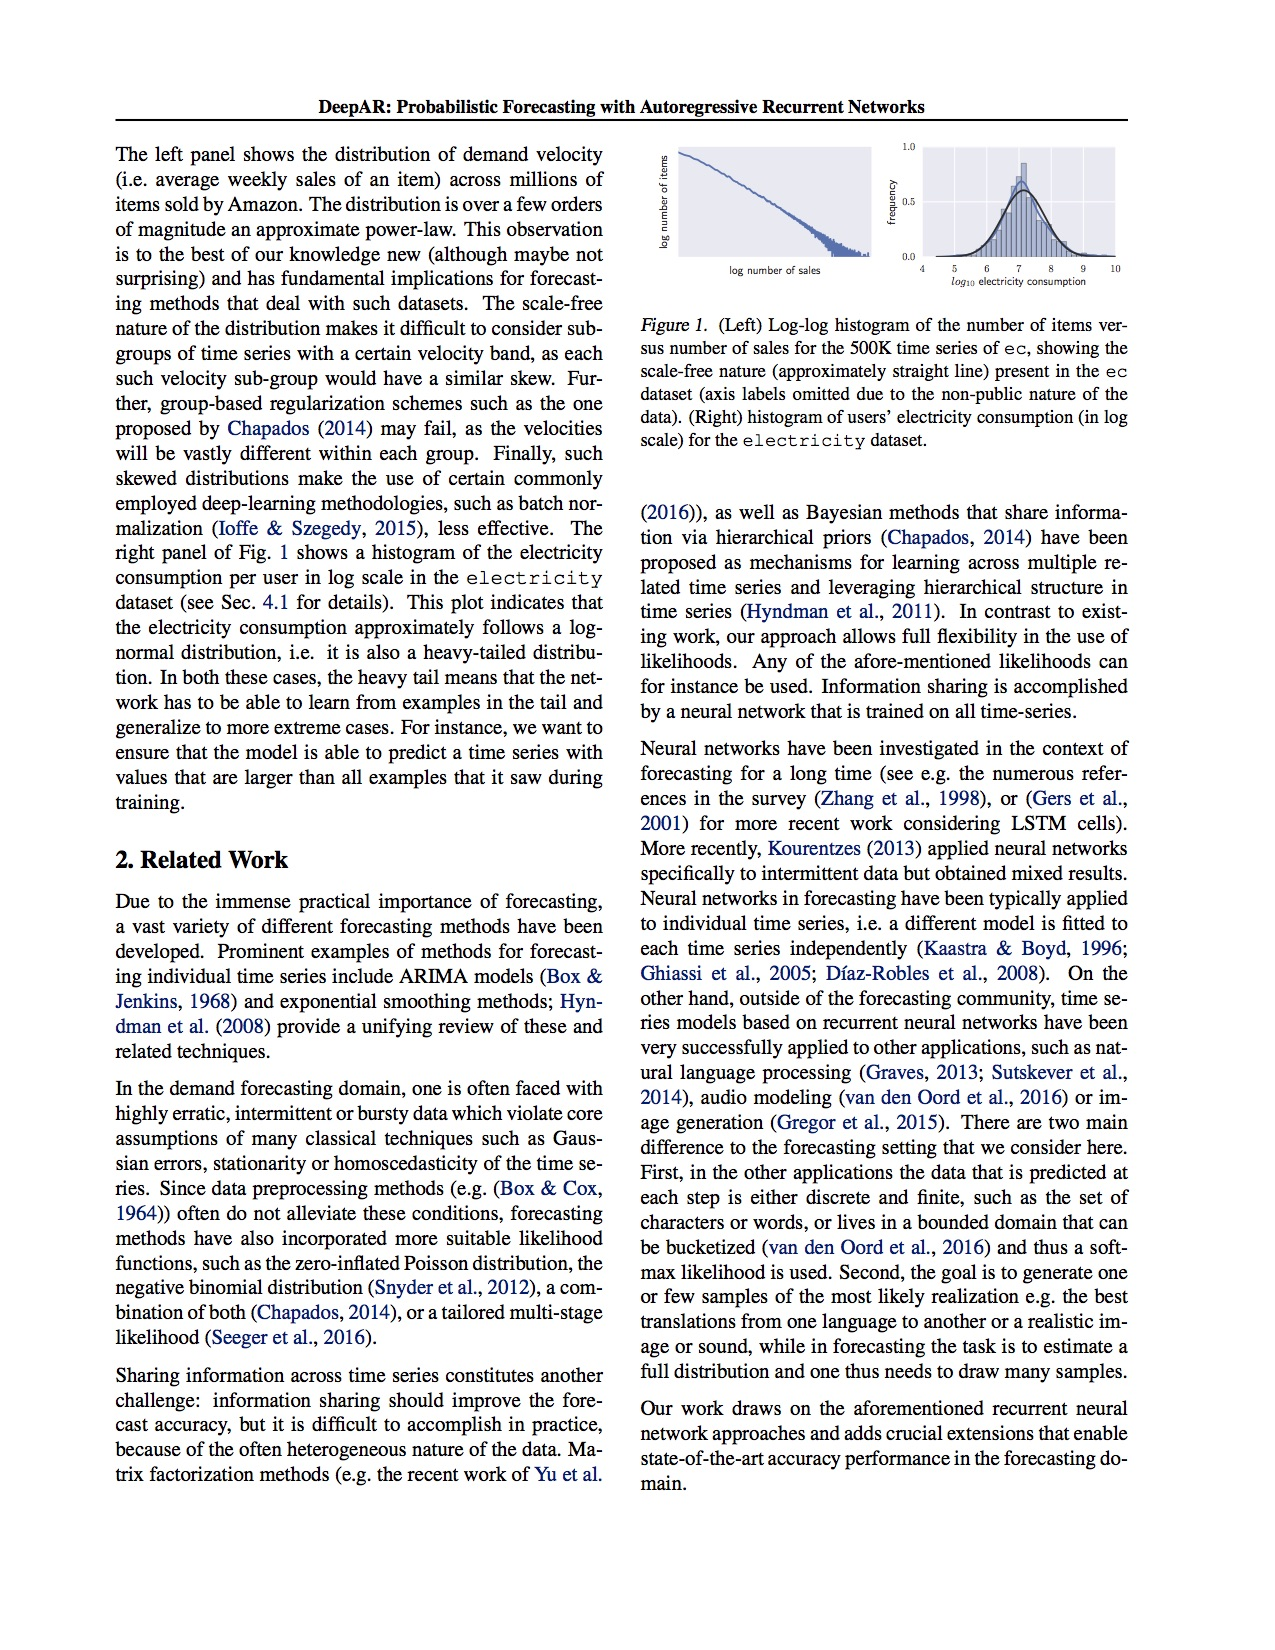

In [53]:
from IPython.display import Image
Image("deepar.jpg", width='50%')

### Read in the image 
above and get the encoded byte array ready

In [62]:
import boto3
import io
from io import BytesIO

fh = open('deepar.jpg', 'rb')
ba = bytearray(fh.read())
stream = io.BytesIO(ba)
image_bytes = stream.getvalue()

### Calling Textract

In [63]:
textract = boto3.client('textract', region_name=TEXTRACT_REGION)
response = textract.analyze_document(Document={'Bytes': image_bytes}, FeatureTypes=["TABLES", "FORMS"])

In [55]:
page_text = ''

for block in response['Blocks']:
    if block['BlockType'] == 'LINE':
        page_text += block['Text'] + '\n'

print(page_text[0:400] + ".......")

DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks
The left panel shows the distribution of demand velocity
(i.e. average weekly sales of an item) across millions of
items sold by Amazon The distribution is over a few orders
of magnitude an approximate power-law. This observation
is to the best of our knowledge new (although maybe not
surprising) and has fundamental implicati.......


### AWS Comprehend 
Extracting the entities and key phrases

In [66]:
comprehend = boto3.client('comprehend', region_name=COMPREHEND_REGION)
entities = comprehend.detect_entities(Text=page_text[0:5000], LanguageCode='en')
key_phrases = comprehend.detect_key_phrases(Text=page_text[0:5000], LanguageCode='en')

In [91]:
import pandas as pd
entities_dataframe = pd.DataFrame.from_dict(entities['Entities'])
key_phrases_dataframe = pd.DataFrame.from_dict(key_phrases['KeyPhrases'])

### Key Phrases

In [ ]:
display(key_phrases_dataframe.sort_values('Score', ascending=0).head(10))

### Entities 

,BeginOffset,EndOffset,Score,Text,Type
53,4730,4734,0.998555,2014,DATE
5,984,988,0.998553,2014,DATE
21,2722,2726,0.997681,2013,DATE
33,3611,3615,0.997171,2013,DATE
35,3693,3697,0.997027,2014,DATE
9,1368,1372,0.994452,2015,DATE
30,3275,3279,0.993829,1968,DATE
11,1435,1439,0.993516,2014,DATE
50,4628,4632,0.993396,2012,DATE
31,3393,3397,0.992731,2008,DATE


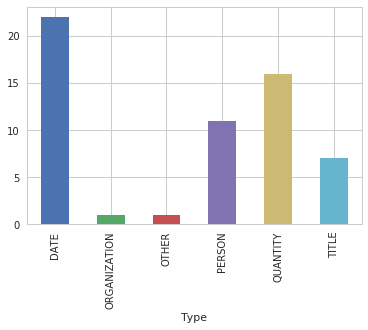

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

display(entities_dataframe.sort_values('Score', ascending=0).head(10))
display(entities_dataframe.groupby('Type').count()['Text'].plot.bar())